In [1]:
!sed -i 's#\(permute(.*\?).*\)#\1.contiguous()#' \
    /opt/conda/lib/python3.10/site-packages/torchvision/models/convnext.py \
    /opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py

In [2]:
from typing import Callable, List, Optional, Union

import os
import re
import logging

from datetime import datetime

from termcolor import colored

import pandas as pd

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, default_collate, random_split

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import BaseFinetuning, BasePredictionWriter, Callback, ModelCheckpoint, BatchSizeFinder

import torchvision
from torchvision import models
import torchvision.transforms as v1
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import default_loader

from torchinfo import summary

from torchmetrics import Accuracy, ConfusionMatrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
NUM_CLASSES = 120

def init_cnn(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

In [6]:
class TrainDataset(VisionDataset):
    def __init__(self, root, csv, transform=None):
        super().__init__(root, transform=transform)
        df = pd.read_csv(csv)
        self.samples = [os.path.join(root, f"{image_id}.jpg") for image_id in df["id"].tolist()]
        targets = df["breed"].tolist()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(set(targets)))}
        self.targets = [self.class_to_idx[label] for label in targets]

    def __getitem__(self, index):
        path = self.samples[index]
        sample = default_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        target = self.targets[index]
        return sample, target

    def __len__(self):
        return len(self.samples)

In [7]:
class PredictDataset(VisionDataset):
    def __init__(self, root, csv, transform=None):
        super().__init__(root, transform=transform)
        df = pd.read_csv(csv)
        self.samples = [os.path.join(root, f"{image_id}.jpg") for image_id in df["id"].tolist()]

    def __getitem__(self, index):
        path = self.samples[index]
        sample = default_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.samples)

In [8]:
class DogData(pl.LightningDataModule):
    def __init__(
        self,
        batch_size=128,
        num_workers=4,
        resize=224,
        aug=None,
        data_dir="/kaggle/input/dog-breed-identification",
        train_images_dirname="train",
        predict_images_dirname="test",
        split=True,
        split_random_seed=42,
        valid_ratio=0.1,
        mix=None,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["aug", "mix"])
        self.data_dir = os.path.expanduser(data_dir)
        self.train_images_dir = os.path.join(data_dir, train_images_dirname)
        self.predict_images_dir = os.path.join(data_dir, predict_images_dirname)
        self.train_csv = os.path.join(data_dir, "labels.csv")
        self.predict_csv = os.path.join(data_dir, "sample_submission.csv")
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.split = split
        self.split_random_seed = split_random_seed
        self.mix = mix
        self.valid_ratio = valid_ratio
        self.trans_train = v1.Compose(
            ([] if aug is None else [aug]) + [
                v1.RandomResizedCrop(resize, scale=(0.64, 1), antialias=True),
                v1.ToTensor(),
                v1.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.trans_test = v1.Compose(
            [
                v1.Resize(resize),
                v1.CenterCrop(resize),
                v1.ToTensor(),
                v1.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.label_map = {
            v: k
            for k, v in TrainDataset(
                self.train_images_dir, self.train_csv, self.trans_train
            ).class_to_idx.items()
        }

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_dataset = TrainDataset(self.train_images_dir, self.train_csv, self.trans_train)
            val_dataset = TrainDataset(self.train_images_dir, self.train_csv, self.trans_test)
            if self.split:
                assert 0.0 < self.valid_ratio < 1.0
                self.train_data, _ = random_split(
                    train_dataset,
                    [1.0 - self.valid_ratio, self.valid_ratio],
                    generator=torch.Generator().manual_seed(self.split_random_seed),
                )
                _, self.val_data = random_split(
                    val_dataset,
                    [1.0 - self.valid_ratio, self.valid_ratio],
                    generator=torch.Generator().manual_seed(self.split_random_seed),
                )
            else:
                self.train_data = train_dataset
                self.val_data = val_dataset
        if stage == "test":
            self.test_data = TrainDataset(self.train_images_dir, self.train_csv, self.trans_test)
        if stage == "predict":
            self.predict_data = PredictDataset(self.predict_images_dir, self.predict_csv, self.trans_test)

    def train_dataloader(self):
        if self.mix is not None:
            collate_fn = lambda batch: self.mix(*default_collate(batch))
        else:
            collate_fn = None

        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [9]:
class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.train_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro")
        self.val_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro")
        self.test_top1_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro")
        self.test_top2_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro", top_k=2)
        self.test_top5_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro", top_k=5)
        self.test_top9_acc = Accuracy("multiclass", num_classes=NUM_CLASSES, average="micro", top_k=9)
        self.confusion_matrix = ConfusionMatrix("multiclass", num_classes=NUM_CLASSES)

    def on_train_epoch_start(self):
        self.train_acc.reset()

    def on_validation_epoch_start(self):
        self.val_acc.reset()

    def on_test_epoch_start(self):
        self.test_top1_acc.reset()
        self.test_top2_acc.reset()
        self.test_top5_acc.reset()
        self.test_top9_acc.reset()
        self.confusion_matrix.reset()

    def training_step(self, batch):
        features, labels = batch
        preds = self(features)
        loss = F.cross_entropy(preds, labels)
        metric = {"train_loss": loss}
        if self.trainer.datamodule.mix is None:
            with torch.no_grad():
                metric["train_acc"] = self.train_acc(preds, labels)
        self.log_dict(metric, prog_bar=True, sync_dist=True)
        return loss

    def on_train_epoch_end(self):
        if self.trainer.datamodule.mix is None:
            self.log_dict({"train_epoch_acc": self.train_acc.compute()}, sync_dist=True)

    def validation_step(self, batch):
        features, labels = batch
        preds = self(features)
        loss = F.cross_entropy(preds, labels)
        acc = self.val_acc(preds, labels)
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch):
        features, labels = batch
        preds = self(features)
        loss = F.cross_entropy(preds, labels)
        top1_acc = self.test_top1_acc(preds, labels)
        top2_acc = self.test_top2_acc(preds, labels)
        top5_acc = self.test_top5_acc(preds, labels)
        top9_acc = self.test_top9_acc(preds, labels)
        self.confusion_matrix(preds, labels)
        self.log_dict(
            {
                "test_loss": loss,
                "test_top1_acc": top1_acc,
                "test_top2_acc": top2_acc,
                "test_top5_acc": top5_acc,
                "test_top9_acc": top9_acc,
            }, sync_dist=True
        )
        return loss

    def on_test_epoch_end(self):
        if self.logger:
            self.logger.log_hyperparams(
                self.hparams,
                {
                    "hp/train_acc": self.train_acc.compute(),
                    "hp/val_acc": self.val_acc.compute(),
                    "hp/test_acc": self.test_top1_acc.compute(),
                },
            )

    def predict_step(self, batch):
        features = batch
        preds = self(features).softmax(dim=1)
        return preds

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters())

In [10]:
class ResNet(Classifier):
    def __init__(self, model: str, pretrained=False):
        super().__init__()
        self.save_hyperparameters()
        available_models = [m for m in models.list_models() if m.startswith('resnet')]
        if model not in available_models:
            raise ValueError(f"{model} should be one of {available_models}.")
        weights = "DEFAULT" if pretrained else None
        self.net = models.get_model(model, weights=weights)
        in_features = self.net.fc.in_features
        self.net.fc = nn.Linear(in_features, NUM_CLASSES)
        self.net.fc.apply(init_cnn)

    def forward(self, X):
        return self.net(X)

    def configure_optimizers(self):
        return torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()))

In [11]:
class RegNet(Classifier):
    def __init__(
        self, model: str, pretrained=False, cosine_t_max: Optional[int] = None, verbose=False, **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        self.cosine_t_max = cosine_t_max
        self.pretrained = pretrained
        self.verbose = verbose
        available_models = [m for m in models.list_models() if m.startswith('regnet')]
        if model not in available_models:
            raise ValueError(f"{model} should be one of {available_models}.")
        if self.pretrained:
            self.net = models.get_model(model, weights="DEFAULT", **kwargs)
            in_features = self.net.fc.in_features
            self.net.fc = nn.Linear(in_features, NUM_CLASSES)
        else:
            self.net = models.get_model(model, num_classes=NUM_CLASSES, **kwargs)
        self.net.fc.apply(init_cnn)

    def forward(self, X):
        return self.net(X)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()))
        if self.cosine_t_max:
            return {
                "optimizer": optimizer,
                "lr_scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                    optimizer, self.cosine_t_max, eta_min=0.00001, verbose=self.verbose
                ),
            }
        else:
            return optimizer

In [12]:
class ConvNeXt(Classifier):
    def __init__(self, model: str, pretrained=False, cosine_t_max=None):
        super().__init__()
        self.save_hyperparameters()
        self.cosine_t_max = cosine_t_max
        available_models = [m for m in models.list_models() if m.startswith('convnext')]
        if model not in available_models:
            raise ValueError(f"{model} should be one of {available_models}.")
        weights = "DEFAULT" if pretrained else None
        self.net = models.get_model(model, weights=weights)
        in_features = self.net.classifier[-1].in_features
        self.net.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
        self.net.classifier.apply(init_cnn)

    def forward(self, X):
        return self.net(X)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()))
        if self.cosine_t_max:
            return {
                "optimizer": optimizer,
                "lr_scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                    optimizer, self.cosine_t_max, eta_min=0.00001, verbose=self.verbose
                ),
            }
        else:
            return optimizer

In [13]:
class Submission(BasePredictionWriter):
    def __init__(self):
        super().__init__(write_interval="epoch")

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        data = trainer.datamodule
        now = datetime.now().strftime("%Y%m%d_%H%M%S")

        df = pd.read_csv(data.predict_csv)
        imgs = df["id"]
        columns = df.columns.tolist()
        columns.pop(0)

        preds = [row.tolist() for item in predictions for row in item]
        submission = pd.concat([imgs, pd.DataFrame(preds, columns=columns)], axis=1)
        submission.to_csv(f"submission_{now}.csv", index=False)

In [14]:
class ConfMatTopK(Callback):
    def __init__(self, top_k):
        self.top_k = top_k
    def on_test_epoch_end(self, trainer, pl_module):
        confmat = pl_module.confusion_matrix.compute()
        errors = confmat.clone()
        errors.fill_diagonal_(0)
        values, indices = errors.view(-1).topk(self.top_k)
        values, indices = values.tolist(), indices.tolist()
        real_indicies = [(i // NUM_CLASSES, i % NUM_CLASSES) for i in indices]

        label_map = trainer.datamodule.label_map

        df = pd.DataFrame(
            [
                [
                    label_map[row],
                    confmat[row, row].item(),
                    label_map[col],
                    value,
                ]
                for value, (row, col) in zip(values, real_indicies)
            ],
            columns=("True label", "Corrects", "Predict label", "Wrongs"),
        )
        print(df.to_markdown())

In [15]:
class ResNetFineTune(BaseFinetuning):
    def __init__(
        self,
        unfreeze_at_epoch=10,
        freeze_again_at_epoch: Optional[int] = None,
        initial_denom_lr=10,
        train_bn=True,
        verbose=False,
    ):
        super().__init__()
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.freeze_again_at_epoch = freeze_again_at_epoch
        self.initial_denom_lr = initial_denom_lr
        self.train_bn_when_freezing = train_bn
        self.verbose = verbose

    def freeze_before_training(self, pl_module):
        backbone = [pl_module.net.get_submodule(k) for k, _ in pl_module.net.named_children() if k != "fc"]
        self.freeze(backbone, train_bn=self.train_bn_when_freezing)

    def finetune_function(self, pl_module, current_epoch, optimizer):
        backbone = [pl_module.net.get_submodule(k) for k, _ in pl_module.net.named_children() if k != "fc"]
        if current_epoch == self.unfreeze_at_epoch:
            self.unfreeze_and_add_param_group(
                modules=backbone,
                optimizer=optimizer,
                initial_denom_lr=self.initial_denom_lr,
                train_bn=(not self.train_bn_when_freezing),
            )
            if self.verbose:
                log.info(
                    f"Current lr: {optimizer.param_groups[0]['lr']}, "
                    f"Backbone lr: {optimizer.param_groups[1]['lr']}"
                )
        elif self.unfreeze_at_epoch is not None and current_epoch == self.freeze_again_at_epoch:
            self.freeze(backbone, train_bn=self.train_bn_when_freezing)
            optimizer.param_groups.pop()

In [16]:
class RegNetFineTune(BaseFinetuning):
    def __init__(
        self,
        unfreeze_at_epoch=10,
        freeze_again_at_epoch: Optional[int] = None,
        initial_denom_lr=10,
        train_bn=True,
    ):
        super().__init__()
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.freeze_again_at_epoch = freeze_again_at_epoch
        self.train_bn_when_freezing = train_bn
        self.initial_denom_lr = initial_denom_lr

        if self.freeze_again_at_epoch is not None:
            assert self.unfreeze_at_epoch < self.freeze_again_at_epoch

    def freeze_before_training(self, pl_module):
        self.freeze([pl_module.net.stem, pl_module.net.trunk_output], train_bn=self.train_bn_when_freezing)

    def finetune_function(self, pl_module, current_epoch, optimizer):
        if current_epoch == self.unfreeze_at_epoch:
            self.unfreeze_and_add_param_group(
                modules=[pl_module.net.stem, pl_module.net.trunk_output],
                optimizer=optimizer,
                initial_denom_lr=self.initial_denom_lr,
                train_bn=(not self.train_bn_when_freezing),
            )
        elif self.unfreeze_at_epoch is not None and current_epoch == self.freeze_again_at_epoch:
            self.freeze(
                [pl_module.net.stem, pl_module.net.trunk_output], train_bn=self.train_bn_when_freezing
            )
            optimizer.param_groups.pop()

In [17]:
class ConvNeXtFineTune(BaseFinetuning):
    def __init__(
        self, unfreeze_at_epoch=10, freeze_again_at_epoch: Optional[int] = None, initial_denom_lr=10
    ):
        super().__init__()
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.freeze_again_at_epoch = freeze_again_at_epoch
        self.initial_denom_lr = initial_denom_lr

    def freeze_before_training(self, pl_module):
        self.freeze(pl_module.net.features)

    def finetune_function(self, pl_module, current_epoch, optimizer):
        if current_epoch == self.unfreeze_at_epoch:
            self.unfreeze_and_add_param_group(
                modules=pl_module.net.features,
                optimizer=optimizer,
                initial_denom_lr=self.initial_denom_lr,
            )
        elif self.unfreeze_at_epoch is not None and current_epoch == self.freeze_again_at_epoch:
            self.freeze(pl_module.net.features)
            optimizer.param_groups.pop()

In [18]:
def save_best_val_acc(prefix, dirpath=None):
    if prefix:
        filename = f"{prefix}-" + "{epoch:02d}-{val_acc:.4f}"
    else:
        filename = "{epoch:02d}-{val_acc:.4f}"
    return ModelCheckpoint(
        dirpath=dirpath,
        monitor="val_acc",
        filename=filename,
        save_weights_only=True,
        mode="max",
        save_on_train_epoch_end=False,
        save_top_k=2,
        save_last=True,
    )

In [19]:
class LayerSummary(Callback):
    def __init__(self, depth=3):
        self.depth = depth

    def on_fit_start(self, trainer, pl_module):
        batch, _ = next(iter(trainer.datamodule.val_dataloader()))
        batch = batch.to(pl_module.device)
        print(
            summary(
                pl_module,
                input_data=batch,
                col_names=("input_size", "output_size", "num_params", "mult_adds"),
                depth=self.depth,
                verbose=0
            )
        )

In [20]:
def train(
    model: Union[pl.LightningModule, str],
    epoch: int,
    pretrained=False,
    dirpath: Optional[str] = None,
    callbacks: Optional[Union[List[Callback], Callback]] = None,
    logger_version: Optional[Union[int, str]] = None,
    checkpoint_path: Optional[str] = None,
    weights_path: Optional[str] = None,
    data=None,
    batch_size=128,
    num_workers=4,
    resize=224,
    aug: Optional[Callable] = None,
    split=True,
    split_random_seed=42,
    mix: Optional[Callable] = None,
    test=True,
    predict=True,
    **kwargs,
):
    if isinstance(model, str):
        model = DefinedNet(model, pretrained=pretrained)

    if checkpoint_path is not None:
        state = torch.load(checkpoint_path)
        model.load_state_dict(state["state_dict"], strict=False)
    elif weights_path is not None:
        state = torch.load(weights_path)
        assert "state_dict" not in state.keys()
        model.load_state_dict(state, strict=False)

    if data is None:
        data = DogData(
            batch_size=batch_size,
            num_workers=num_workers,
            resize=resize,
            aug=aug,
            split=split,
            split_random_seed=split_random_seed,
            mix=mix,
        )
    # logger = TensorBoardLogger(".", default_hp_metric=False, version=logger_version)
    logger=CSVLogger(save_dir=".", version=logger_version)

    model_name = model.hparams.get("model", model.__class__.__name__)
    if model_name:
        print(colored(f"Start training {model_name} in {epoch} epoches...", "green"))
    ck = [save_best_val_acc(model_name, dirpath=best_model_dirpath)]
    if test:
        ck += [ConfMatTopK(20)]
    if predict:
        ck += [Submission()]
    if callbacks:
        if isinstance(callbacks, Callback):
            callbacks = [callbacks]
        ck += callbacks

    trainer = pl.Trainer(max_epochs=epoch, logger=logger, callbacks=ck, **kwargs)
    trainer.fit(model, datamodule=data)
    if test:
        trainer.test(model, datamodule=data)

    if predict:
        trainer.predict(model, datamodule=data)
        trainer.predict(model, datamodule=data, ckpt_path='best')

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_val_acc(
    log_dir, acc_ylim=(0.5, 1.0), save_loss=None, save_acc=None):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"

    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

In [23]:
def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.3, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

In [24]:
class FineTuneBatchSizeFinder(BatchSizeFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.scale_batch_size(trainer, pl_module)

In [25]:
!rm -rf ./lightning_logs/convnext_tiny && rm -rf ./checkpoints

In [26]:
epoch = 10
model_name = 'convnext_tiny'
batch_size = 128

model = ConvNeXt(model_name, pretrained=True)
data = DogData(batch_size=batch_size)
logger = CSVLogger(save_dir=".", version='convnext_tiny', flush_logs_every_n_steps=10)
trainer = pl.Trainer(max_epochs=epoch, logger=logger,
                     callbacks=[
                         LayerSummary(),
                         ConvNeXtFineTune(1,9,100),
                         save_best_val_acc(model_name, dirpath='checkpoints'),
                     ],
                     precision='16-mixed',
                     accelerator="gpu", devices=2, strategy="ddp_notebook",
                     log_every_n_steps=10)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 101MB/s]  


In [27]:
trainer.fit(model, datamodule=data)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Mult-Adds
ConvNeXt                                           [128, 3, 224, 224]        [128, 120]                --                        --
├─ConvNeXt: 1-1                                    [128, 3, 224, 224]        [128, 120]                --                        --
│    └─Sequential: 2-1                             [128, 3, 224, 224]        [128, 768, 7, 7]          --                        --
│    │    └─Conv2dNormActivation: 3-1              [128, 3, 224, 224]        [128, 96, 56, 56]         (4,896)                   1,888,247,808
│    │    └─Sequential: 3-2                        [128, 96, 56, 56]         [128, 96, 56, 56]         (237,888)                 5,808,844,800
│    │    └─Sequential: 3-3                        [128, 96, 56, 56]         [128, 192, 28, 28]        (74,112)                  7,418,044,416
│    │    └─Sequential: 3-4         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

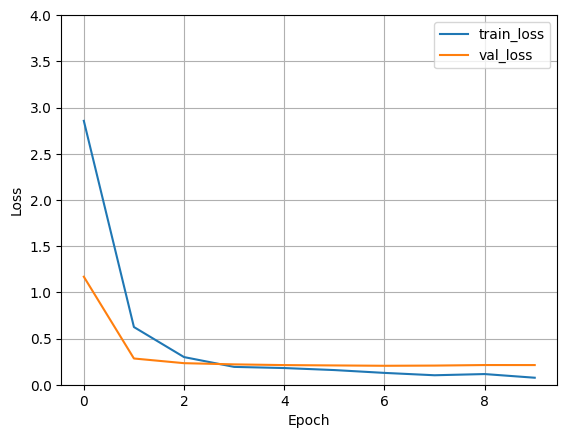

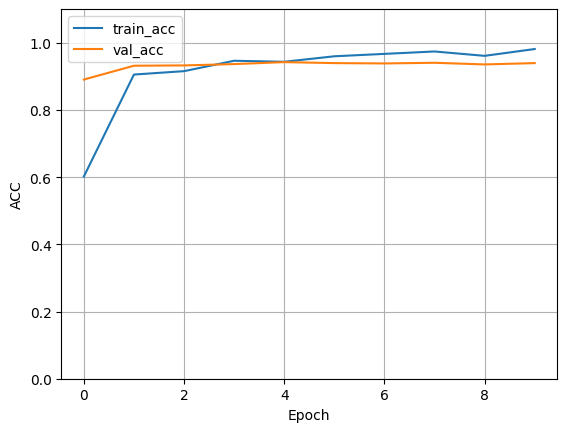

In [28]:
plot_loss_and_acc(
    trainer.logger.log_dir, 
    loss_ylim=(0.0, 3.0),
    acc_ylim=(0.8, 1.1)
)

In [29]:
trainer_test = pl.Trainer(max_epochs=0, logger=False, callbacks=[ConfMatTopK(20), Submission()],
                          precision='16-mixed',
                          accelerator='gpu', devices=1,
                          log_every_n_steps=10)

In [30]:
trainer_test.test(model, datamodule=data);

Testing: |          | 0/? [00:00<?, ?it/s]

|    | True label                     |   Corrects | Predict label                  |   Wrongs |
|---:|:-------------------------------|-----------:|:-------------------------------|---------:|
|  0 | eskimo_dog                     |         47 | siberian_husky                 |       15 |
|  1 | collie                         |         72 | border_collie                  |       10 |
|  2 | american_staffordshire_terrier |         67 | staffordshire_bullterrier      |        7 |
|  3 | english_foxhound               |         77 | walker_hound                   |        7 |
|  4 | miniature_poodle               |         71 | toy_poodle                     |        6 |
|  5 | shih-tzu                       |        105 | lhasa                          |        5 |
|  6 | malamute                       |         75 | siberian_husky                 |        5 |
|  7 | staffordshire_bullterrier      |         75 | american_staffordshire_terrier |        4 |
|  8 | lakeland_terrier       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0732126235961914     │
│       test_top1_acc       │    0.9811191558837891     │
│       test_top2_acc       │    0.9973586201667786     │
│       test_top5_acc       │     0.999706506729126     │
│       test_top9_acc       │    0.9999021887779236     │
└───────────────────────────┴───────────────────────────┘

In [31]:
# trainer_test.predict(model, datamodule=data);